<a href="https://colab.research.google.com/github/Sumirsht/BardiyaAGB/blob/main/BardiyaAGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.5 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

In [5]:
from google.colab import auth
auth.authenticate_user()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'MNDWI','NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['agbd']
SAMPLE_PATH = './content/drive/MyDrive/DL_regression/SampleAGB.csv'
IMAGE_PATH = './content/drive/MyDrive/DL_regression/Landsat_100m.tif'

/content
File exists: True


/usr/local/lib/python3.11/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


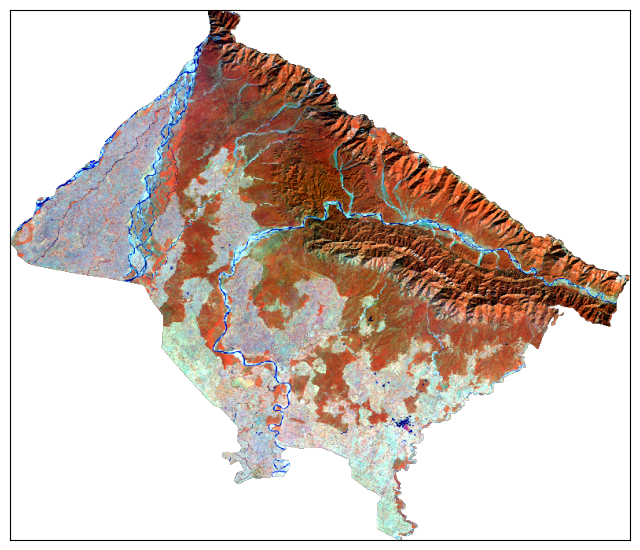

<Axes: >

In [8]:
# Load image
import rasterio # Make sure rasterio is imported
import os

# Verify the file path - Print the current working directory to double check
print(os.getcwd()) # This may not be the same as the path on Google Drive

# Use os.path.join to combine paths safely, reducing potential path errors.
IMAGE_PATH = os.path.join('/content/drive/MyDrive/DL_regression/', 'Landsat_100m.tif')

# Try to access the file directly and print if it exists
print(f'File exists: {os.path.exists(IMAGE_PATH)}')

# If it does open, it should print the DatasetReader object
image = rasterio.open(IMAGE_PATH)

bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [5, 6, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [9]:
# Read sample
SAMPLE_PATH = '/content/drive/MyDrive/DL_regression/SampleAGB.csv' # Use absolute path
samples = pd.read_csv(SAMPLE_PATH)[FEATURES + LABEL]
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,MNDWI,NDWI,NDBI,NDBaI,elevation,agbd
0,0.143429,0.157217,0.215386,0.194544,0.567758,0.421951,0.284500,0.760713,0.799300,0.644193,0.206702,0.125809,0.355807,0.687469,0.677079,126.105450
1,0.144721,0.157979,0.220895,0.201644,0.552974,0.434337,0.304814,0.743218,0.766959,0.618452,0.205501,0.137615,0.381548,0.670011,0.674052,72.796318
2,0.159091,0.182051,0.245692,0.228045,0.524661,0.454356,0.326163,0.708467,0.721258,0.571443,0.226251,0.179853,0.428557,0.659927,0.667077,283.663054
3,0.149513,0.174998,0.252416,0.255972,0.575204,0.475180,0.346594,0.721957,0.733635,0.594370,0.220075,0.161475,0.405630,0.652734,0.690675,34.413806
4,0.132087,0.145138,0.229450,0.229819,0.525224,0.410755,0.295313,0.694320,0.759798,0.620496,0.237827,0.160262,0.379504,0.659243,0.690675,24.918038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.118922,0.136926,0.217629,0.172239,0.501273,0.365103,0.245171,0.714961,0.806963,0.653384,0.262160,0.158595,0.346616,0.689214,0.511199,272.068447
69,0.139266,0.156995,0.231646,0.199775,0.525433,0.385866,0.279083,0.721850,0.779959,0.649642,0.264919,0.162734,0.350358,0.656550,0.508760,43.609652
70,0.129547,0.147885,0.233538,0.192126,0.518240,0.397140,0.269713,0.718379,0.786870,0.630019,0.256949,0.168796,0.369981,0.684356,0.508140,209.564063
71,0.114924,0.135564,0.219736,0.165064,0.507936,0.357434,0.231260,0.724704,0.828300,0.668811,0.274273,0.157644,0.331189,0.704915,0.510595,281.053811


In [10]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True)

# Get varibles input and output
train_input = train[FEATURES].to_numpy()
test_input = test[FEATURES].to_numpy()
train_output = train[LABEL].to_numpy().astype(float) / 450
test_output = test[LABEL].to_numpy().astype(float) / 450

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (58, 15)
Test features: (15, 15)
Train label: (58, 1)
Test label: (15, 1)


In [11]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1],)

# Model parameter
neuron = 32
drop = 0.2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Dense(neuron * 4, activation='relu'),
  Dropout(drop),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(1, activation='relu')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='mse',
    metrics=['MeanSquaredError']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(train_input, train_output),
    batch_size=1,
    callbacks=[stop],
    epochs=50,
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - MeanSquaredError: 0.1288 - loss: 0.1288 - val_MeanSquaredError: 0.0600 - val_loss: 0.0600
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0923 - loss: 0.0923 - val_MeanSquaredError: 0.0625 - val_loss: 0.0625
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0898 - loss: 0.0898 - val_MeanSquaredError: 0.0595 - val_loss: 0.0595
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0763 - loss: 0.0763 - val_MeanSquaredError: 0.0784 - val_loss: 0.0784
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0719 - loss: 0.0719 - val_MeanSquaredError: 0.0610 - val_loss: 0.0610
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0821 - loss: 0.0821 - val_MeanSquaredError: 0.0767 - val_loss: 0.0767
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MeanSquaredError: 0.0630 - loss: 0.0630 - val_MeanSquaredError: 0.0615 - val_loss: 0.0615
Epoch 

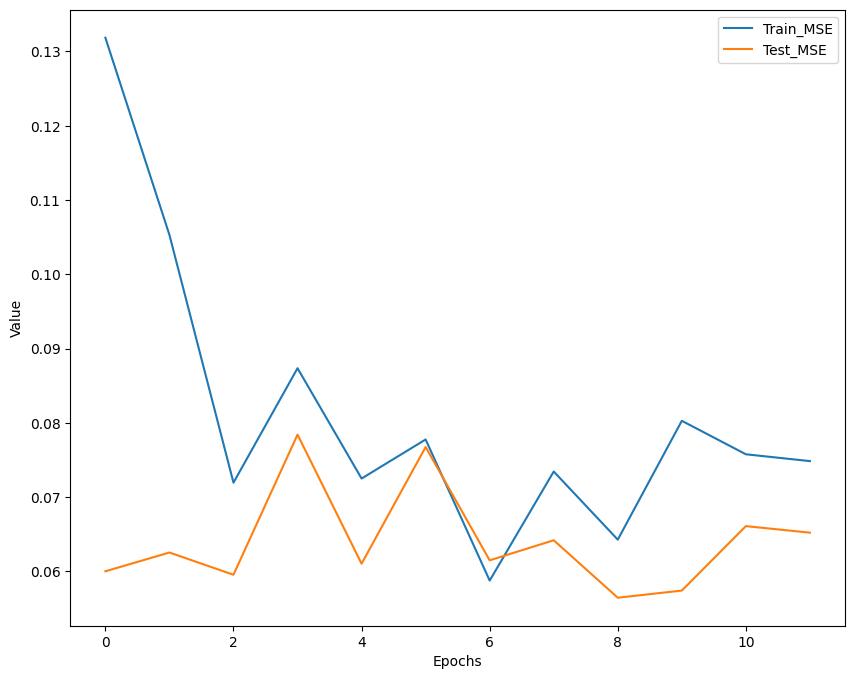

In [13]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['MeanSquaredError'].values.tolist())), history['MeanSquaredError'].values.tolist(), label = 'Train_MSE') # Changed 'mean_squared_error' to 'MeanSquaredError'
plt.plot(range(len(history['val_MeanSquaredError'].values.tolist())), history['val_MeanSquaredError'].values.tolist(), label = 'Test_MSE') # Changed 'val_mean_squared_error' to 'val_MeanSquaredError'
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
R^2: -0.07923239868820042
MSE: 0.049788734318422484


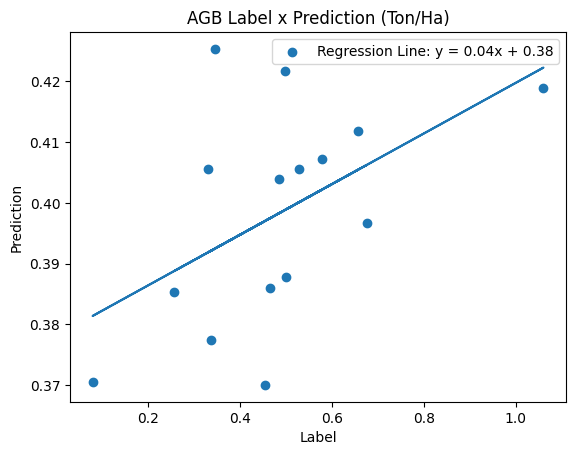

In [14]:
# Predict test data
prediction = model.predict(test_input).flatten()
label = test_output.flatten()

# R2 and RMSE
r2 = r2_score(label, prediction)
mse = mean_squared_error(label, prediction)
print(f'R^2: {r2}\nMSE: {mse}')

# Plot
plt.scatter(label, prediction)
m, b = np.polyfit(label, prediction, 1)
plt.plot(label, m*label + b)
plt.title('AGB Label x Prediction (Ton/Ha)')
plt.xlabel('Label')
plt.ylabel('Prediction')
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m,b)])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


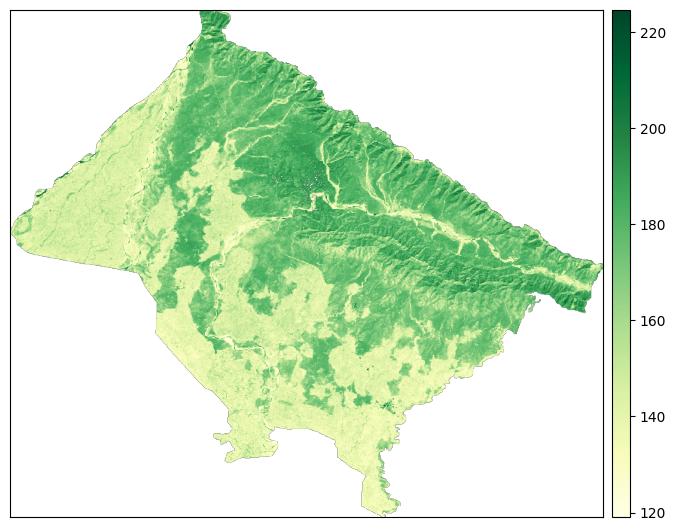

<Axes: >

In [15]:
# Predict image using the model
image_input = []
for x in range(len(FEATURES)):  # Changed to iterate over the number of features
  image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(len(FEATURES), -1).T # Reshape using len(FEATURES)

# Predict
prediction = model.predict(image_input, batch_size=4096*20) * 450
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
ep.plot_bands(prediction, cmap='YlGn', figsize=plot_size)

In [16]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL_regression/'
name = 'AGB.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()